In [9]:
from typing import TypedDict #define the structure (shape) of a dictionary with specific keys and value types.
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

In [10]:
load_dotenv()

True

In [11]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [12]:
subgraph_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [13]:
def translate_text(state: SubState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["input_text"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

In [14]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [15]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [16]:
parent_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [17]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [18]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [19]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

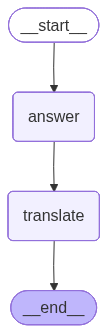

In [20]:
graph = parent_builder.compile()

graph

In [21]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics, also known as **quantum mechanics**, is a fundamental branch of physics that studies the behavior of matter and energy at the most microscopic scales – specifically, at the level of **atoms and subatomic particles** (like electrons, protons, and photons).\n\nHere\'s a breakdown of what makes it so distinct and fascinating:\n\n1.  **The Scale:** While classical physics (like Newton\'s laws of motion or Maxwell\'s equations of electromagnetism) accurately describes the world we experience every day (planets, cars, light bulbs), these rules break down completely when you zoom into the realm of the extremely small. Quantum physics provides the rules for *that* tiny world.\n\n2.  **It\'s "Quantized":** The word "quantum" comes from the Latin word for "how much." One of the core ideas is that many physical properties, like energy, come in discrete, indivisible packets called **quanta**. Imagine climbing stairs instead o